In [16]:
# Variables

USER = 'apache' # github user of the repo that is analysed
REPO = 'log4j' # repo to investigate
BASE_PATH = '/Users/philippepossemiers/Documents/Dev/Spark/data/analyzer/' # local expansion path
COMMENT_LINES = ['/*', '//', '*/', '* '] # remove comments from code
KEY_WORDS = ['abstract','continue','for','new','switch','assert','default','goto','synchronized',
            'boolean','do','if','private','this','break','double','implements','protected','throw',
            'byte','else','public','throws','case','enum','instanceof','return','transient',
            'catch','extends','int','short','try','char','final','interface','static','void',
            'class','finally','long','strictfp','volatile','const','float','native','super','while'
            'true','false','null']
TOP = 25 # number of items to show in graphs

In [17]:
# Imports and directives

%matplotlib inline
#from pyspark import SparkContext
import numpy as np
import matplotlib.pyplot as plt
import javalang
from collections import Counter
import os, re, requests, zipfile, json, operator
from StringIO import StringIO
from pyspark.ml.feature import Tokenizer, RegexTokenizer, HashingTF, IDF
from subprocess import Popen, PIPE

In [18]:
# Global dictionaries

commit_dict = {} # commits per class
reference_dict = {} # number of times a class is referenced
lines_dict = {} # number of lines per class
functions_dict = {} # number of functions per class

In [64]:
# Utility functions

def all_files(directory):
    for path, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.join(path, f)

def sanitize(contents):
    lines = contents.split('\n')

    # remove stop lines
    for stop_line in COMMENT_LINES:
        lines = [line.lower().lstrip().replace(';', '') for line in lines if stop_line not in line and line <> '']
    
    return '\n'.join(lines)

def find_whole_word(word):
    return re.compile(r'\b({0})\b'.format(word), flags=re.IGNORECASE).search
    
def parse_git_log(repo_dir):
    commits = {}
    p = Popen('git log --name-only --pretty=format:', shell=True, stdout=PIPE, cwd=repo_dir)
    (log, _) = p.communicate()
    log = log.strip('\n\x1e').split('\x1e')
    log = [r.strip().split('\n') for r in log]
    log = [r for r in log[0] if '.java' in r and 'src' in r]
    cnt_dict = Counter(log)
    
    return cnt_dict

def count_references(src):
    names, tups = zip(*src)
    refs = {e : 0 for i, e in enumerate(names)}

    for name in names:
        c_name = name[name.rfind('.'):]
        for tup in tups:
            if find_whole_word(c_name)(tup[0]):
                refs[name] += 1
    
    # sort by amount of references
    return {k: v for k, v in refs.iteritems() if v > 1}

def count_lines(src):
    counts = {e : 0 for i, e in enumerate(src)}

    for name, tup in src:
        lines = tup[0].split('\n')
        counts[name] = len(lines)
    
    # sort by amount of lines
    return {k: v for k, v in counts.iteritems()}

def count_functions(src):
    funcs = {e : 0 for i, e in enumerate(src)}
    
    for name, tup in src:
        funcs[name] = len(tup[1].types[0].methods)
        
    # sort by amount of functions
    return {k: v for k, v in funcs.iteritems()}


def make_hbar_plot(dictionary, title, x_label, top=TOP):
    # show top classes
    vals = sorted(dictionary.values(), reverse=True)[:top]
    lbls = sorted(dictionary, key=dictionary.get, reverse=True)[:top]

    # make plot
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(111)

    # set ticks
    y_pos = np.arange(len(lbls)) + 0.5
    ax.barh(y_pos, vals, align='center', alpha=0.4, color='darksalmon')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lbls)
    ax.set_xlabel(x_label)

    plt.show()
    pass

In [65]:
joined = []
# get all java source files
src_files = [f for f in all_files(BASE_PATH + REPO) if f.endswith('.java') and 'src' in f]

for f in src_files:
    # read contents
    code = open(f, 'r').read()
    tree = javalang.parse.parse(code)
    # create tuple with package + class name and code + tree
    joined.append((tree.package.name + '.' + tree.types[0].name, (code, tree)))

In [73]:
commit_dict = parse_git_log(BASE_PATH + REPO)
tst = {}
v = 'src/java/org/apache/log4j/Category.java'
i = joined.index(v)

tree = javalang.parse.parse(open(joined[i], 'r').read())
tst[tree.package.name + '.' + tree.types[0].name] = commit_dict[v]
print tst

ValueError: 'src/java/org/apache/log4j/Category.java' is not in list

## Commit frequency

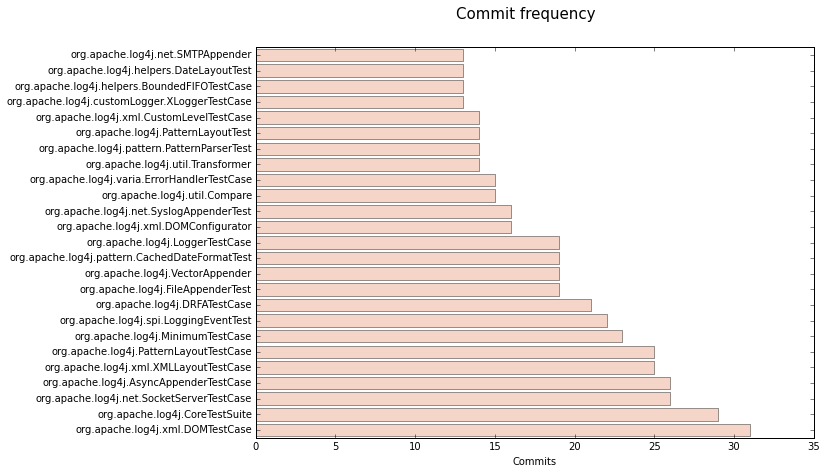

In [21]:
repo_url = 'https://github.com/' + USER + '/' + REPO
os.chdir(BASE_PATH)
os.system('git clone {}'.format(repo_url))

commit_dict = parse_git_log(BASE_PATH + REPO)
#print json.dumps(commit_dict, indent=4, sort_keys=True)
make_hbar_plot(commit_dict, 'Commit frequency', 'Commits', 25)

## Class reference count

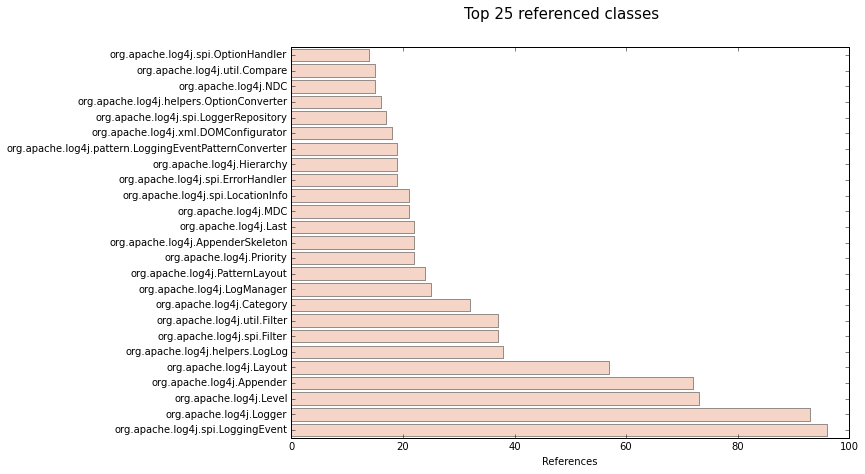

In [58]:
reference_dict = count_references(joined)
make_hbar_plot(reference_dict, 'Top 25 referenced classes', 'References', 25)

## Lines of code

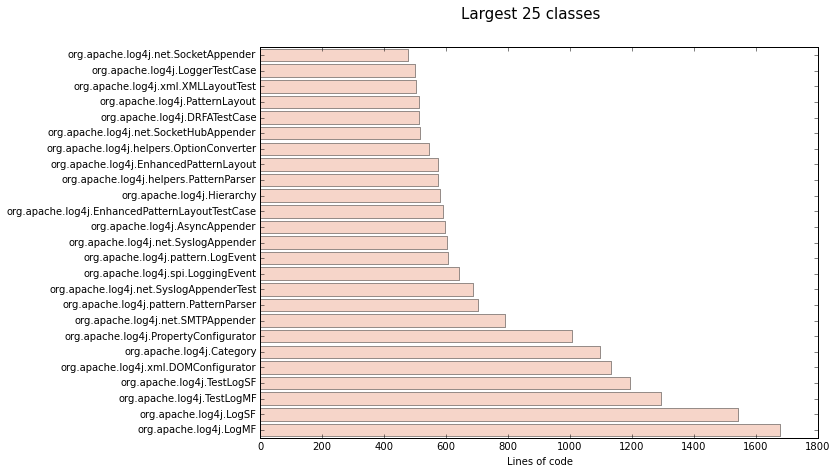

In [60]:
lines_dict = count_lines(joined)
make_hbar_plot(lines_dict, 'Largest 25 classes', 'Lines of code', 25)

## Number of functions

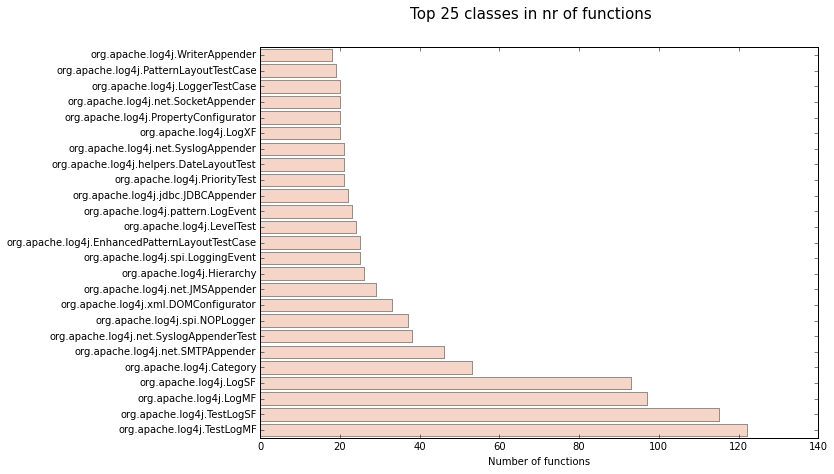

In [62]:
functions_dict = count_functions(joined)
make_hbar_plot(functions_dict, 'Top 25 classes in nr of functions', 'Number of functions', 25)